# Analysis of StackOverflow Survey. Part I

In [1]:
# import neccessary packages and libraries
import os
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

from sklearn.linear_model import LinearRegression

from sklearn import (
    ensemble,
    preprocessing,
    tree,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from sklearn.metrics import (
    r2_score, 
    mean_squared_error,
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

In [2]:
# import local module containing the neccessary functions
import utils_functions as uf

# forces the interpreter to re-import the module
import importlib
importlib.reload(uf);

## Ask Questions

The well known questions and answers website Stack Overflow has been conducted annual surveys for a decade now.  These are the largest and the most comprehensive surveys of coders ever conducted. The anonymized results of the surveys are publicly available for analysis at [Stack Overflow Anual Developer Survey](https://insights.stackoverflow.com/survey).

The 2020 Stack Overflow Survey was conducted in February 2020, just before the COVID-19 pandemic affected the entire world. The survey consists of 60 questions distributed over six sections:

1. Basic Information
2. Education, Work, Career
3. Technology and Tech Culture
4. Stack Overflow Usage + Community
5. Demographic Information
6. Survey Opinion and Final Questions

The survey had 64461 (almost 65k) responses from 184 countries and regions.

I am interested in learning more about those developers who work with big data, such as data scientists, machine learning engineers, data and business analysts and data engineers. I call them data coders for short. In this analysis I will answer the following questions:

1. Do data coders have more formal educational background than the other coders? 
2. How does the salary of data coders compare with the salary of the other coders? 
3. Predict the job satisfaction of a data coder and determine the key factors affecting it.

## Gather Data and Check the Uploads

There are two csv files:
 - `results_public.csv` contains the survey results;
 - `results_schema.csv` contains the list of columns in the first file, together with their associated questions. 

In [173]:
# create a path string
mypath = os.getcwd()

# upload the datafiles as pandas dataframes
df = pd.read_csv(mypath+'/data/survey20_results_public.csv')
dfs = pd.read_csv(mypath+'/data/survey20_results_schema.csv')

In [4]:
# option to display the full text of the string columns
pd.set_option('display.max_colwidth', None)

In [5]:
# peek at the survey file
df.head(2)

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or software engineering",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or software engineering",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4


In [6]:
# peek at the description file
dfs.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order of survey response time)
1,MainBranch,"Which of the following options best describes you today? Here, by ""developer"" we mean ""someone who writes code."""
2,Hobbyist,Do you code as a hobby?
3,Age,"What is your age (in years)? If you prefer not to answer, you may leave this question blank."
4,Age1stCode,"At what age did you write your first line of code or program? (e.g., webpage, Hello World, Scratch project)"


## Investigate the Data

In [7]:
# get the shape of the data
df.shape

(64461, 61)

In [8]:
# save the column names as a list for later investigation if needed
cols = list(dfs.Column.unique())
# print(cols)

In [9]:
# general data information including the non-null values
#df.info();

In [10]:
# get the number of NaN values in each column
df_null = df.isnull().sum()
#df_null

In [11]:
# the columns with no missing data
no_null = set(df.columns[np.sum(df.isnull()) == 0]) 
no_null

{'Respondent'}

In [12]:
# there are no columns with more than 50% values missing
most_missing_cols = df.columns[df.isnull().mean() > 0.50]
most_missing_cols

Index([], dtype='object')

In [13]:
# most missing values, in descending order, written as percentages
df.isnull().mean().sort_values(ascending=False).round(3)

ConvertedComp             0.461
CompTotal                 0.460
NEWPurchaseResearch       0.421
PurchaseWhat              0.389
WebframeDesireNextYear    0.379
                          ...  
Employment                0.009
Country                   0.006
MainBranch                0.005
Hobbyist                  0.001
Respondent                0.000
Length: 61, dtype: float64

In [14]:
# columns with more than 30% of the values missing
most_missing_vals = df.columns[df.isnull().mean() > 0.30]
#print(most_missing_vals)

In [15]:
# look at the numerical data
df.describe().round(2) 

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.00,45446.00,3.482600e+04,34756.00,41151.00
mean,32554.08,30.83,3.190464e+242,103756.05,40.78
std,18967.44,9.59,inf,226885.30,17.82
min,1.00,1.00,0.000000e+00,0.00,1.00
25%,16116.00,24.00,2.000000e+04,24648.00,40.00
50%,32231.00,29.00,6.300000e+04,54049.00,40.00
75%,49142.00,35.00,1.250000e+05,95000.00,44.00
max,65639.00,279.00,1.111111e+247,2000000.00,475.00


#### Observations on the numerical data:
- the column with most missing values is `ConvertedComp`, almost half of the values are missing;
- more than 30% values are missing in the `WorkWeekHours`;
- there are outliers in the numerical columns, as we can see from min/max values.

#### Generate a profiling report 
The more recent `pandas_profiling` library builds a profile report of the data. It summarizes all the important information regarding the data, including missing data and high cardinality data. Use the minimal mode that disables expensive computations (such as correlations and dynamic binning) to avoid 'maximum allowed size' error.

In [16]:
# run this once to generate the report and save it as html file

# import pandas_profiling
# profile = pandas_profiling.ProfileReport(df, minimal=True)
# profile.to_file(output_file="data_report.html")

## Specific Information from Data

### Distribution by country

In [17]:
# the number of countries involved
len(df.Country.unique())

184

In [18]:
# distribution of respondents per country
country_counts = df.Country.value_counts()
country_counts.head()

United States     12469
India              8403
United Kingdom     3896
Germany            3890
Canada             2191
Name: Country, dtype: int64

In [19]:
# distribution of respondents on countries using percentages
df.Country.value_counts(normalize=True) * 100

United States                         19.460919
India                                 13.114933
United Kingdom                         6.080659
Germany                                6.071295
Canada                                 3.419590
                                        ...    
Chad                                   0.001561
Lesotho                                0.001561
North Korea                            0.001561
Kiribati                               0.001561
Micronesia, Federated States of...     0.001561
Name: Country, Length: 183, dtype: float64

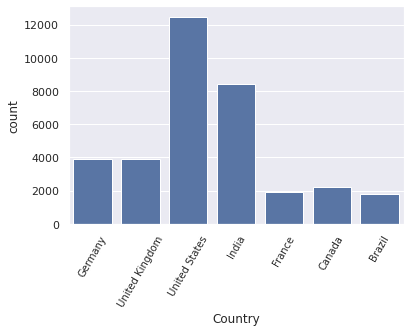

In [20]:
# the most represented countries, with more than 2000 respondents
df_most_repres_countries = df[df.Country.map(df.Country.value_counts()) > 1500]

# bar chart of the most represented countries
sns.countplot(data = df_most_repres_countries, x='Country', color='b');
# rotate the xtixks
plt.xticks(size=10, rotation = 60);

In [21]:
# percentage of most represented countries respondents
df_most_repres_countries.shape[0]/df.shape[0] * 100

53.6215696312499

In [22]:
# countries with less than 100 respondents
least_represented_countries = country_counts[country_counts < 100]
len(least_represented_countries)

114

#### Observations on countries distribution of respondents:
- there are 184 countries and territories,
- 53% of the respondents come from 7 countries with more than 15k respondents per country,
- the countries with largest number of respondents are US (almost 20%) and India (13%),
- more than 100 (114 to be precise) have fewer than 100 respondents.

### Distribution of respondents by gender

In [23]:
# distribution by gender in counts
df.Gender.value_counts()

Man                                                            46013
Woman                                                           3844
Non-binary, genderqueer, or gender non-conforming                385
Man;Non-binary, genderqueer, or gender non-conforming            121
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         76
Woman;Man;Non-binary, genderqueer, or gender non-conforming       26
Name: Gender, dtype: int64

In [24]:
# distribution by gender in percentages
# notice that this method excludes NaN values
df.Gender.value_counts(normalize=True) * 100

Man                                                            91.012125
Woman                                                           7.603299
Non-binary, genderqueer, or gender non-conforming               0.761517
Man;Non-binary, genderqueer, or gender non-conforming           0.239334
Woman;Non-binary, genderqueer, or gender non-conforming         0.181973
Woman;Man                                                       0.150325
Woman;Man;Non-binary, genderqueer, or gender non-conforming     0.051427
Name: Gender, dtype: float64

In [25]:
# to evaluate percentages with respect to full size of the set, including the NaN values
df.Gender.value_counts(normalize=True, dropna=False) * 100

Man                                                            71.381145
NaN                                                            21.569631
Woman                                                           5.963296
Non-binary, genderqueer, or gender non-conforming               0.597260
Man;Non-binary, genderqueer, or gender non-conforming           0.187710
Woman;Non-binary, genderqueer, or gender non-conforming         0.142722
Woman;Man                                                       0.117901
Woman;Man;Non-binary, genderqueer, or gender non-conforming     0.040334
Name: Gender, dtype: float64

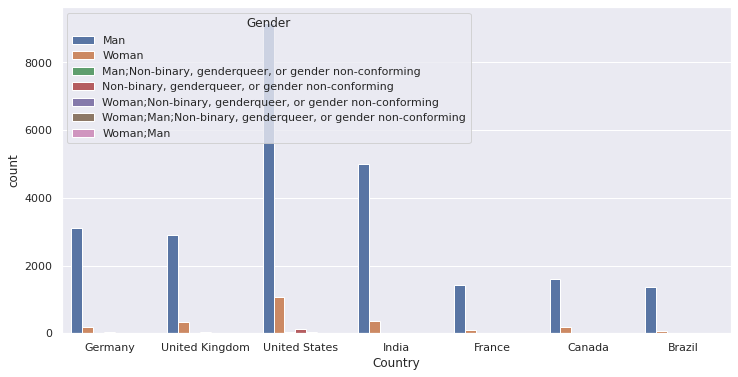

In [26]:
# distribution by gender and country, for the countries with most respondents
# set the figure size
plt.figure(figsize = [12,6])

# adapted clustered bar chart of country and gender
sns.countplot(data=df_most_repres_countries, x='Country', hue='Gender');

#### Observations regarding the distribution by gender:
- with more than 21% of the gender values missing, 71% of the respondents are male.

**Remark**

I will compute percentages relative to the entire dataset, including NaN counts. 

### Who are the developers?

In [27]:
# distribution by MainBranch professional level
df.MainBranch.value_counts(normalize=True, dropna=False) * 100

I am a developer by profession                                                   73.211709
I am a student who is learning to code                                           12.364065
I am not primarily a developer, but I write code sometimes as part of my work     8.535393
I code primarily as a hobby                                                       3.589767
I used to be a developer by profession, but no longer am                          1.835218
NaN                                                                               0.463846
Name: MainBranch, dtype: float64

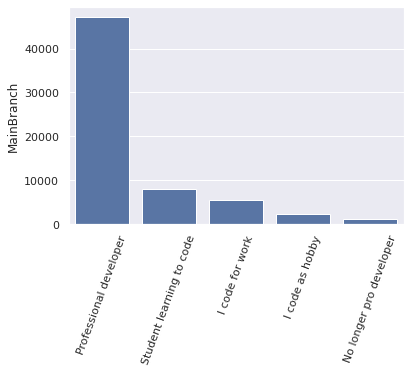

In [28]:
# plot the value counts with their categories
g = sns.barplot(x=df.MainBranch.value_counts().index, y=df.MainBranch.value_counts(), color='b');
# create a list of shorter labels
new_ticks = ['Professional developer', 'Student learning to code', 
             'I code for work', 'I code as hobby', 'No longer pro developer']
# change and rotate the xticks
g.set_xticklabels(new_ticks, rotation=70);

In [29]:
# distribution by Hobbyist in percentages - if developers code as hobby
df.Hobbyist.value_counts(normalize=True, dropna=False) * 100

Yes    78.168195
No     21.761996
NaN     0.069810
Name: Hobbyist, dtype: float64

#### Observations regarding the professional distribution of the respondents:
- there are very few missing values, about 0.4%, in the professional status
- more than 73% of the respondents are professional developers.

### What type of developer are you?

In [30]:
# rename the data engineer string in the full dataset
df['DevType'] = df['DevType'].str.replace('Engineer, data', 'Data engineer')

In [31]:
# respondents choose more than one answer as we can see below
DevType_counts = df.DevType.value_counts().reset_index()
DevType_counts.head(4)

,index,DevType
0,"Developer, full-stack",4424
1,"Developer, back-end",3086
2,"Developer, back-end;Developer, front-end;Developer, full-stack",2227
3,"Developer, back-end;Developer, full-stack",1476


In [32]:
# how many combinations are there
DevType_counts.shape[0]

8269

In [33]:
# rename the columns in the results dataframe
DevType_counts.rename(columns = {'index':'devChoice', 'DevType':'count'}, inplace=True)
DevType_counts.head(2)

,devChoice,count
0,"Developer, full-stack",4424
1,"Developer, back-end",3086


In [34]:
# create a list of the individual answers that can be marked by a user
dev_choice = list(DevType_counts.devChoice.str.split(';', expand=True)[0].unique())
print(dev_choice)

['Developer, full-stack', 'Developer, back-end', 'Developer, front-end', 'Developer, mobile', 'Developer, desktop or enterprise applications', 'Developer, embedded applications or devices', 'Data scientist or machine learning specialist', 'Data or business analyst', 'Developer, QA or test', 'Designer', 'Academic researcher', 'Engineering manager', 'Data engineer', 'DevOps specialist', 'System administrator', 'Database administrator', 'Developer, game or graphics', 'Senior executive/VP', 'Scientist', 'Product manager', 'Educator', 'Engineer, site reliability', 'Marketing or sales professional']


In [35]:
# we create an adjusted dev_choice list, with no data coders
dev_choice_short = [x for x in dev_choice if not 'Data ' in x]
print(dev_choice_short)

['Developer, full-stack', 'Developer, back-end', 'Developer, front-end', 'Developer, mobile', 'Developer, desktop or enterprise applications', 'Developer, embedded applications or devices', 'Developer, QA or test', 'Designer', 'Academic researcher', 'Engineering manager', 'DevOps specialist', 'System administrator', 'Database administrator', 'Developer, game or graphics', 'Senior executive/VP', 'Scientist', 'Product manager', 'Educator', 'Engineer, site reliability', 'Marketing or sales professional']


In [36]:
# the list of types of developers working with data
data_dev = [x for x in dev_choice if 'Data ' in x]
print(data_dev)

['Data scientist or machine learning specialist', 'Data or business analyst', 'Data engineer']


In [37]:
# count the individual choices strings in the column DevTypes
dev_types = uf.counts_strings(dev_choice,df,'DevType')
#developers_types

In [38]:
# rename the columns in the results dataframe
dev_types.rename(columns = {'index':'DevTypes', 0:'counts'}, inplace=True)
dev_types.head(2)

,DevTypes,counts
0,"Developer, full-stack",27125
1,"Developer, back-end",27228


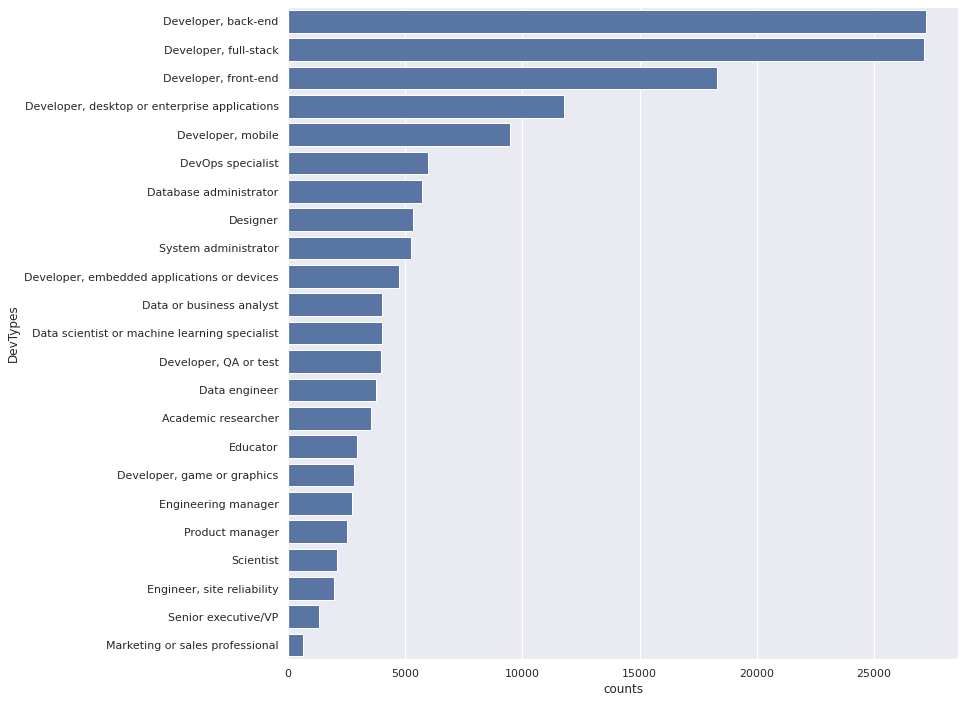

In [39]:
# set the figure size
plt.figure(figsize = [12,12])

# sort values
devs_types = dev_types.sort_values('counts', ascending=False)

# plot the value counts with their categories
sns.barplot(y=devs_types.DevTypes, x=devs_types.counts, color='b');

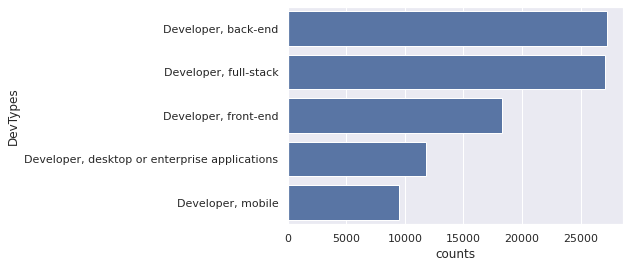

In [40]:
# look at the most popular choices
devs_types = dev_types.sort_values('counts', ascending=False).head(5)

# plot the value counts with their categories
sns.barplot(y=devs_types.DevTypes, x=devs_types.counts, color='b');

#### Observations regarding the distribution of the developers types:
- most of the respondents identify themselves as back-end, full-stack or front-end developers. 

## Data preparation

### Create a column to label the developers in data coders and other developers


In [115]:
# create a copy of the dataframe
df1 = df.copy()

In [116]:
# use np.where(condition, value if condition is true, value if condition is false)
# create column DevClass, entry data_coder or other_coder, based on DevType contains data or not
df1['DevClass'] = np.where(df1["DevType"].str.contains("Data ", na = False), 'data_coder', 'other_coder')
df1.DevClass.value_counts()

other_coder    55735
data_coder      8726
Name: DevClass, dtype: int64

### Change some descriptions into shorter strings

In [117]:
# get the choices for the education level question
edLevel_list = list(df1.EdLevel.unique())
edLevel_list

['Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
 nan,
 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
 'Professional degree (JD, MD, etc.)',
 'Some college/university study without earning a degree',
 'Associate degree (A.A., A.S., etc.)',
 'Other doctoral degree (Ph.D., Ed.D., etc.)',
 'Primary/elementary school',
 'I never completed any formal education']

In [118]:
# create a dictionary with shorter strings for education levels
new_edLevel = {'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'Master’s degree',
 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'Bachelor’s degree',
 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':  'Secondary school',
 'Professional degree (JD, MD, etc.)': 'Professional degree',
 'Some college/university study without earning a degree': 'College study/no degree',
 'Associate degree (A.A., A.S., etc.)' : 'Associate degree',
 'Other doctoral degree (Ph.D., Ed.D., etc.)': 'Other doctoral degree',
 'I never completed any formal education' : 'No formal education'}

In [119]:
# check for success
df1.replace(new_edLevel, inplace=True)
df1.EdLevel.unique()

array(['Master’s degree', 'Bachelor’s degree', nan, 'Secondary school',
       'Professional degree', 'College study/no degree',
       'Associate degree', 'Other doctoral degree',
       'Primary/elementary school', 'No formal education'], dtype=object)

In [120]:
# take a look of the undegraduate major options
df1.UndergradMajor.unique()

array(['Computer science, computer engineering, or software engineering',
       nan, 'Mathematics or statistics',
       'Another engineering discipline (such as civil, electrical, mechanical, etc.)',
       'A humanities discipline (such as literature, history, philosophy, etc.)',
       'A health science (such as nursing, pharmacy, radiology, etc.)',
       'Information systems, information technology, or system administration',
       'Web development or web design',
       'A natural science (such as biology, chemistry, physics, etc.)',
       'Fine arts or performing arts (such as graphic design, music, studio art, etc.)',
       'I never declared a major',
       'A social science (such as anthropology, psychology, political science, etc.)',
       'A business discipline (such as accounting, finance, marketing, etc.)'],
      dtype=object)

In [174]:
# create a dictionary with shorter descriptions for the undegraduate majors
new_UndergradMajor = {'Computer science, computer engineering, or software engineering':
                           'Computer science',
       'Another engineering discipline (such as civil, electrical, mechanical, etc.)':'Engineering other',
       'A humanities discipline (such as literature, history, philosophy, etc.)': 'Humanities',
       'A health science (such as nursing, pharmacy, radiology, etc.)': 'Health science',
       'Information systems, information technology, or system administration' : 'Information system',
       'Web development or web design': 'Web dev/design',
        'Mathematics or statistics': 'Math or stats',
       'A natural science (such as biology, chemistry, physics, etc.)': 'Natural science',
       'Fine arts or performing arts (such as graphic design, music, studio art, etc.)': 'Arts',
       'I never declared a major': 'No major',
       'A social science (such as anthropology, psychology, political science, etc.)': 'Social science',
       'A business discipline (such as accounting, finance, marketing, etc.)': 'Business'}

In [122]:
# check for success
df1.replace(new_UndergradMajor, inplace=True)
df1.UndergradMajor.unique()

array(['Computer science', nan, 'Mathematics or statistics',
       'Engineering other', 'Humanities', 'Health science',
       'Information system', 'Web dev/design', 'Natural science', 'Arts',
       'No major', 'Social science', 'Business'], dtype=object)

In [175]:
# replace some strings in the EdImpt column
new_EdImpt = {'Not at all important/not necessary': 'Not important'}
df1.replace(new_EdImpt, inplace=True)
df1.EdImpt.unique()

array(['Fairly important', 'Not important', 'Very important',
       'Somewhat important', nan, 'Critically important'], dtype=object)

### Drop columns not used in our analysis

In [123]:
# list of columns not used in our analysis
drop_cols = ['CompFreq', 'CompTotal', 'CurrencyDesc', 'CurrencySymbol',
             'Ethnicity', 'NEWOffTopic', 'NEWOnboardGood', 
             'NEWOtherComms', 'NEWPurchaseResearch', 
             'PurchaseWhat', 'Sexuality', 'SOComm', 
             'SurveyEase', 'SurveyLength', 'Trans',  'WelcomeChange',
             'Age','Age1stCode','YearsCode','YearsCodePro',
             'NEWSOSites', 'SOAccount', 'SOPartFreq', 'SOVisitFreq',
             'DatabaseDesireNextYear', 'LanguageDesireNextYear',
             'MiscTechDesireNextYear', 'MiscTechWorkedWith',
             'NEWCollabToolsDesireNextYear', 'PlatformDesireNextYear', 
             'WebframeDesireNextYear']

In [124]:
# drop all the columns in the list drop_cols
df1 = df1.drop(drop_cols, axis = 1)

# check the shape of the new dataset
df1.shape

(64461, 31)

#### Change some column names

In [125]:
# drop the NEW prefix in some of the columns' names
df1.columns = [col.replace('NEW', '') for col in df1.columns]
df1.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'ConvertedComp', 'Country',
       'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'Gender',
       'JobFactors', 'JobSat', 'JobSeek', 'LanguageWorkedWith',
       'CollabToolsWorkedWith', 'DevOps', 'DevOpsImpt', 'EdImpt', 'JobHunt',
       'JobHuntResearch', 'Learn', 'Overtime', 'PurpleLink', 'Stuck', 'OpSys',
       'OrgSize', 'PlatformWorkedWith', 'UndergradMajor', 'WebframeWorkedWith',
       'WorkWeekHrs', 'DevClass'],
      dtype='object')

#### Drop rows with missing entries

In [129]:
# keep only the rows with at least 15 non-NA values
df1 = df1.dropna(thresh=10)
df1.shape

(60430, 31)

### Impute data in ConvertedComp column

In [130]:
# take a look at the records statistics
df1.ConvertedComp.describe().round(3)

count      34754.000
mean      103751.916
std       226890.778
min            0.000
25%        24648.000
50%        54049.000
75%        95000.000
max      2000000.000
Name: ConvertedComp, dtype: float64

In [133]:
# there are numerous extreme values and also almost half of values missing
df1.ConvertedComp.sort_values(ascending=False)

18296    2000000.0
56738    2000000.0
32330    2000000.0
4011     2000000.0
19251    2000000.0
           ...    
64447          NaN
64453          NaN
64456          NaN
64459          NaN
64460          NaN
Name: ConvertedComp, Length: 60430, dtype: float64

In [132]:
# the extreme values
df1[df1.ConvertedComp == 2000000].shape

(258, 31)

In [135]:
# impute the ConvertedComp missing values with the median of the corresponding country
# save the existing values and the imputed values in a new column
df1['imputedComp'] = df1['ConvertedComp'].fillna(df1.groupby('Country')['ConvertedComp'].transform('median'))

In [137]:
# check how many values are still missing
df1.imputedComp.isnull().sum()

48

In [151]:
# fill the remaining NaN values by 0
df1['imputedComp'] = df1['imputedComp'].fillna(0)

# check for success
df1[df1.imputedComp.isna()].shape

(0, 32)

In [153]:
# check the dimensions of the processed dataframe
df1.shape

(60430, 32)

### Save the processed dataframe to a file

In [159]:
# save a copy of the prepared dataframe
df1.to_csv(mypath + '/data/survey20_updated.csv')

## The data coders

Look at the subset of developers who checked at least one of the options of working with big data. These options are 'Data scientist or machine learning specialist', 'Data or business analyst' and 'Engineer, data'.

In [154]:
# the subset of developers that checked at least one data related profession
data_coders = df1[df1["DevClass"] == 'data_coder']
data_coders.shape

(8706, 32)

In [155]:
# the percentage of data coders among all respondents
data_coders.shape[0]/df1.shape[0] * 100

14.406751613437036

In [156]:
# the developers that did not check any data related professions
other_coders = df1[df1["DevClass"] == 'other_coder']
other_coders.shape

(51724, 32)

In [157]:
# what other DevTypes do the data coders choose
data_coders_groups = uf.counts_strings(dev_choice_short,data_coders,'DevType')
# rename the columns
data_coders_groups.rename(columns = {'index':'DevTypes', 0:'counts_data'}, inplace=True)
# add a column with percentages computed with respect to all data coders
data_coders_groups['perc_data'] = (data_coders_groups.counts_data/data_coders.shape[0] * 100).round(2)
# show the results ordered by counts and percentages
data_coders_groups.sort_values('counts_data', ascending=False).head(2)

,DevTypes,counts_data,perc_data
1,"Developer, back-end",4833,55.51
0,"Developer, full-stack",3805,43.71


In [158]:
# what DevTypes do the other developers choose
other_coders_groups = uf.counts_strings(dev_choice_short, other_coders,'DevType')
# rename the columns in the results table
other_coders_groups.rename(columns = {'index':'DevTypes', 0:'counts_other'}, inplace=True)
# add a column with percentages computed with respect to all other coders
other_coders_groups['perc_other'] = (other_coders_groups.counts_other/other_coders.shape[0] * 100).round(2)
# show the results ordered by counts
other_coders_groups.sort_values('counts_other', ascending=False).head(2)

,DevTypes,counts_other,perc_other
0,"Developer, full-stack",23286,45.02
1,"Developer, back-end",22367,43.24


#### Observations regarding DevTypes barplot:
- this barplot is misleading since the developers choose more than one DevType, and the sums of percentages do not add to 100, the comparison is meaningless.

## Scribbles

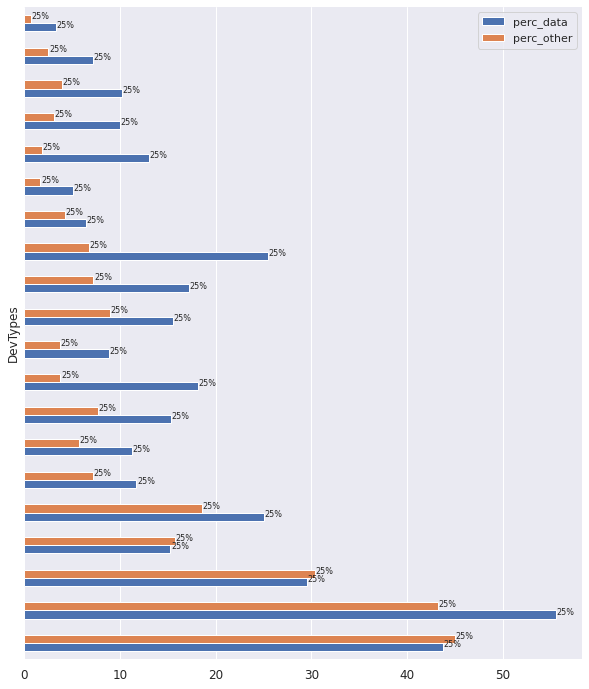

In [192]:
# plot the data side by side
temp_groups = pd.merge(data_coders_groups, other_coders_groups, on='DevTypes')

# horizontal barplot with the percentages 
sided_plot = temp_groups.plot(x = 'DevTypes', y = ['perc_data','perc_other'], 
                              kind='barh', figsize=(10, 12));
plt.xlabel('')

plt.xticks(fontsize=12)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in sided_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    sided_plot.annotate(f'{height:.0%}',
                        (x + width + 1, y + height/2), ha='center', fontsize=8)

In [235]:
def df_counts(dff, old_col, new_col, perc_name):
    new_dff = pd.DataFrame(dff[old_col].value_counts()/dff.shape[0]).reset_index()
    new_dff.rename(columns = {'index': new_col, old_col: perc_name}, inplace=True)
    return new_dff
    

In [291]:
# merge the three databases
#df_temp = pd.merge(all_perc, other_perc, on = 'Education')
#df_temp_new = pd.merge(df_temp, data_perc, on = 'Education')
#df_temp_new

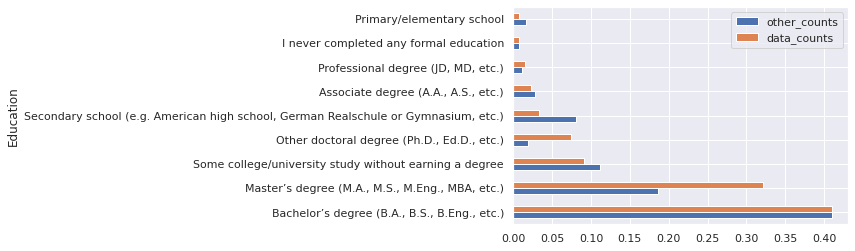

In [305]:
# plot the data
temp_ed = merge_df(data_perc, other_perc, 'Education')
sided_plot = temp_ed.plot(x = 'Education', y = ['other_counts','data_counts'], kind="barh")
plt.xlabel('');


In [ ]:
# an example of a query on data
pd.DataFrame(df.query(condition).groupby(['Gender', 'FormalEducation']).mean()['Salary'])

In [ ]:
# fill NaN in a specific column
df_copy[['DevType']] = df_copy[['DevType']].fillna('none') # Specific columns

In [ ]:
# drop those rows that have null values in DevType column
df1 = df.dropna(subset=['DevType'], axis=0)